                     Constant Mean - GARCH Model Results                      
Dep. Variable:            Log_Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                5093.74
Distribution:                  Normal   AIC:                          -10179.5
Method:            Maximum Likelihood   BIC:                          -10157.1
                                        No. Observations:                 1992
Date:                Wed, Jun 05 2024   Df Residuals:                     1991
Time:                        10:34:33   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -9.6262e-07  3.073e-04 -3.133e-03      0.

/Users/suraj/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003821. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/var/folders/vz/29vpj_7x23d83y_wsskdx1wc0000gn/T/ipykernel_3440/3240288112.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Forecasted_Volatility'] = np.sqrt(in_sample_forecast.variance.values[-len(train_data):])


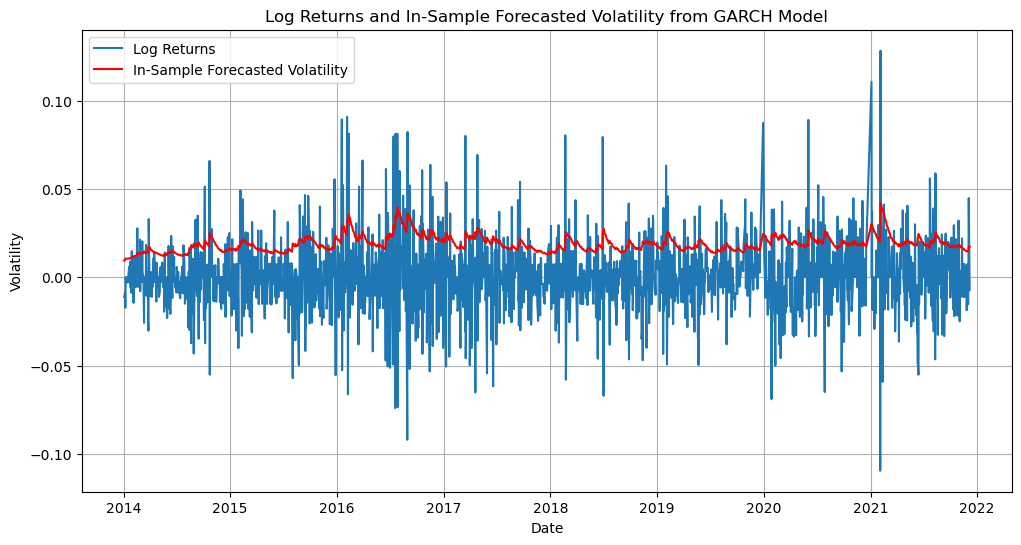

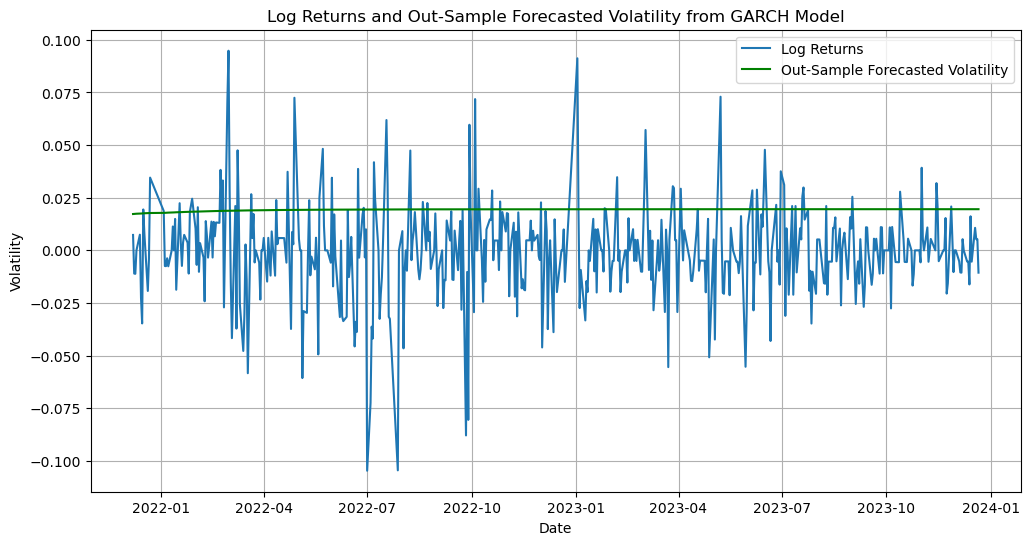

In [18]:
import pandas as pd
import numpy as np
from datetime import datetime
from arch import arch_model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Load the new dataset
file_path = '/Users/suraj/Downloads/rea_holdings_share_prices.csv'
data = pd.read_csv(file_path)

# Parse the Date column to datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%d.%m.%Y')

# Sort the data by date
data = data.sort_values(by='Date')

# Set the Date column as the index
data.set_index('Date', inplace=True)

# Log returns calculation
data['Log_Returns'] = np.log(data['Price']).diff()
data = data.dropna()  # Remove NaN values

# Ensure log returns contain only finite values
assert np.isfinite(data['Log_Returns']).all()

# Split the data into training and testing sets
train_size = int(len(data) * 0.8)
train_data, test_data = data[:train_size], data[train_size:]

# Fit the GARCH(1, 1) model on the training data
model = arch_model(train_data['Log_Returns'], vol='Garch', p=1, q=1)
garch_fit = model.fit(disp='off')

# Summary of the model
garch_summary = garch_fit.summary()
print(garch_summary)

# In-sample forecasting on the training data
in_sample_forecast = garch_fit.forecast(start=0)
train_data['Forecasted_Volatility'] = np.sqrt(in_sample_forecast.variance.values[-len(train_data):])

# Out-of-sample forecasting
forecast_horizon = len(test_data)  # Forecast for the next 20% of the data

# Generate the forecast for the out-of-sample period
out_of_sample_forecast = garch_fit.forecast(horizon=forecast_horizon, start=len(train_data) - 1)
out_of_sample_variance = out_of_sample_forecast.variance[-forecast_horizon:]
out_of_sample_volatility = np.sqrt(out_of_sample_variance.values.flatten())

# Debugging: Print lengths to check alignment
print(f'Length of out-of-sample forecasted values: {len(out_of_sample_volatility)}')
print(f'Length of test data: {len(test_data)}')

# Ensure lengths match
assert len(out_of_sample_volatility) == len(test_data), f"Length of forecasted values ({len(out_of_sample_volatility)}) does not match length of test data ({len(test_data)})"

# Add the out-of-sample forecasted volatility to the test data
test_data = test_data.copy()  # Avoid SettingWithCopyWarning
test_data['Forecasted_Volatility'] = out_of_sample_volatility

# Check the accuracy of the prediction using Mean Squared Error
mse = mean_squared_error(test_data['Log_Returns'], test_data['Forecasted_Volatility'])
print(f'Mean Squared Error of the out-of-sample forecast: {mse}')

# Plot the conditional volatility and forecasted volatility for in-sample
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train_data['Log_Returns'], label='Log Returns')
ax.plot(train_data['Forecasted_Volatility'], color='red', label='In-Sample Forecasted Volatility')
ax.set_title('Log Returns and In-Sample Forecasted Volatility from GARCH Model')
ax.set_ylabel('Volatility')
ax.set_xlabel('Date')
ax.legend()
plt.grid(True)
plt.show()

# Plot the conditional volatility and forecasted volatility for out-of-sample
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(test_data['Log_Returns'], label='Log Returns')
ax.plot(test_data['Forecasted_Volatility'], color='green', label='Out-Sample Forecasted Volatility')
ax.set_title('Log Returns and Out-Sample Forecasted Volatility from GARCH Model')
ax.set_ylabel('Volatility')
ax.set_xlabel('Date')
ax.legend()
plt.grid(True)
plt.show()


Mean Squared Error of the out-of-sample price forecast: 36471.53406901812


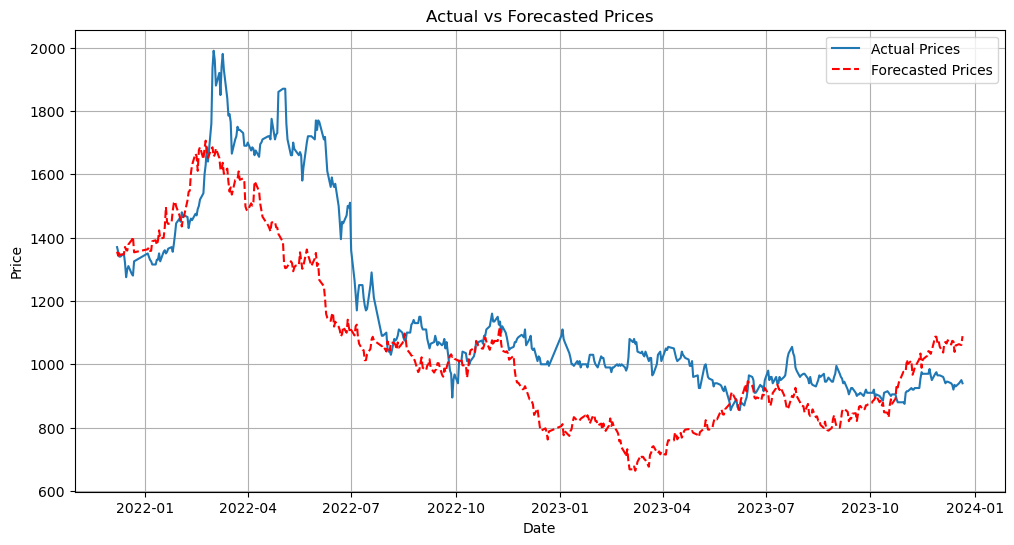

In [20]:
# Assuming the same setup and forecast steps have been done as before

# Ensure we are using the log returns forecasted by the model for price prediction
test_data['Forecasted_Returns'] = test_data['Forecasted_Volatility'] * np.random.normal(size=len(test_data))

# Convert the forecasted log returns to cumulative returns and then to prices
initial_price = train_data['Price'].iloc[-1]  # Last price from the training set
test_data['Forecasted_Prices'] = initial_price * np.exp(test_data['Forecasted_Returns'].cumsum())

# Calculate the Mean Squared Error for price prediction
mse_prices = mean_squared_error(test_data['Price'], test_data['Forecasted_Prices'])
print(f'Mean Squared Error of the out-of-sample price forecast: {mse_prices}')

# Plot the actual prices and forecasted prices
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(test_data['Price'], label='Actual Prices')
ax.plot(test_data['Forecasted_Prices'], color='red', linestyle='--', label='Forecasted Prices')
ax.set_title('Actual vs Forecasted Prices')
ax.set_ylabel('Price')
ax.set_xlabel('Date')
ax.legend()
plt.grid(True)
plt.show()
